In [4]:
import sys

In [5]:
BASE_DIR = "../.."
DATA_DIR = f"{BASE_DIR}/data"
NBDATA_DIR = f"{BASE_DIR}/nbdata"
FIG_DIR = f"{BASE_DIR}/figs"

In [6]:
sys.path.append(BASE_DIR)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [8]:
import anndata as ad
import scanpy as sc

## Load Name Mappings

In [9]:
hgnc_name_map = pd.read_csv(f"{NBDATA_DIR}/iPSC_ENSG_HGNC_mapping.tsv",sep="\t").set_index('ENSG')

als_mapping = pd.read_csv(f"{NBDATA_DIR}/iPSC_rna_als_genie_integer_edgelist_0.999_MAP.tsv",sep="\t",header=None)
als_name_dict = {}
for i, ensg in zip(als_mapping.iloc[:,1], als_mapping.iloc[:,0]):
    als_name_dict[i] = hgnc_name_map.loc[ensg,'HGNC']
    
ctr_mapping = pd.read_csv(f"{NBDATA_DIR}/iPSC_rna_ctr_genie_integer_edgelist_0.999_MAP.tsv",sep="\t",header=None)
ctr_name_dict = {}
for i, ensg in zip(ctr_mapping.iloc[:,1], ctr_mapping.iloc[:,0]):
    ctr_name_dict[i] = hgnc_name_map.loc[ensg,'HGNC']

## Load mFinder Output

In [10]:
out_basename = "../../nbdata/iPSC_rna_{}_genie_integer_edgelist_0.999_mfinder_s{}_OUT.txt"
member_basename = "../../nbdata/iPSC_rna_{}_genie_integer_edgelist_0.999_mfinder_s{}_MEMBERS.txt"

In [11]:
class GeneralMotif():
    
    def __init__(self,
                 size,
                 matrix,
                 motif_id,
                 nreal,
                 nrand_stats,
                 nreal_zscore,
                 nreal_pval
                ):
        self.motif_id = motif_id
        self.nreal = nreal
        self.nrand_stats = nrand_stats
        self.nreal_zscore = nreal_zscore
        self.nreal_pval = nreal_pval

        self.matrix = matrix
        self.size = size
        self.graph = nx.from_numpy_matrix(self.matrix,create_using=nx.DiGraph)
        assert self.matrix.shape[0] == self.size
        assert self.matrix.shape[1] == self.size
    
    def __lt__(self,other):
        return self.nreal_pval < other.nreal_pval
    
    def __eq__(self,other):
        return (self.matrix == other.matrix).all()
    
    def __repr__(self):
        return str(self.matrix)
    
    def __hash__(self):
        return hash(str(self.matrix))
    
    def view(self,savefig=None,do_hash=False,node_size=2000,node_color='lightgrey',**kwargs):
        sns.set(style='whitegrid',font_scale=1)
        fig, ax1 = plt.subplots(figsize=(8,6))
        nx.draw_networkx(self.graph,
                         arrows=True,
                         arrowsize=45,
                         node_size=node_size,
                         node_color=node_color,
                         ax=ax1,
                         **kwargs
                        )
        plt.axis('off')
        plt.title(f"Motif ID {self.motif_id} -- pvalue: {self.nreal_pval} {f'(hash={hash(self)})' if do_hash else ''}")
        if savefig:
            plt.savefig(savefig,bbox_inches='tight')
        plt.show()
        
    def make_specific(self, member_list):
        spec_motif = Motif(
            self.size,
            self.matrix,
            self.motif_id,
            self.nreal,
            self.nrand_stats,
            self.nreal_zscore,
            self.nreal_pval,
            member_list = member_list
        )
        return spec_motif
        
class Motif(GeneralMotif):
    
    def __init__(self, *args, member_list=[]):
        super().__init__(*args)
        self.members = member_list
        self.node_mapping = {}
        for i, nm in zip(range(self.size), self.members):
            self.node_mapping[i] = nm
        self.graph = nx.relabel_nodes(self.graph, self.node_mapping)
        
    def __hash__(self):
        return hash(str(self.matrix)+','.join(self.members))
    
    def __repr__(self):
        return str(pd.DataFrame(self.matrix,index=self.members,columns=self.members))

def parse_mfinder_outfile(condition, size):
    motif_list = []
    finame = out_basename.format(condition,size)
    with open(finame,'r') as f:
        startread = False
        for line in f:
            line = line.strip()
            if 'Full list includes' in line:
                startread = True
                f.readline() # Header line 1
                f.readline() # Header line 2
                f.readline() # Blank line
            elif 'Full list of subgraphs size' in line:
                startread = False
            elif not startread:
                continue
            else:
                try:
                    # In a block
                    mid, nreal, nrand_stats, nreal_z, nreal_p, uniq_val, creal = line.split()
                    f.readline() # Blank line
                    motif_matrix = []
                    for _ in range(size): # Read motif identity
                        motif_matrix.append([int(i) for i in f.readline().strip().split()])
                    motif_matrix = np.array(motif_matrix)
                    motif_list.append(
                        GeneralMotif(
                            size,
                            motif_matrix,
                            int(mid),
                            float(nreal),
                            nrand_stats,
                            float(nreal_z),
                            float(nreal_p),
                        )
                    )
                    f.readline() # Blank line
                except ValueError as e:
                    return motif_list
                
def parse_mfinder_memberfile(condition, size, mlist = None, name_map = None):
    if mlist is None:
        mlist = parse_mfinder_outfile(condition, size)
    finame = member_basename.format(condition, size)
    mdict = {int(m.motif_id): m for m in mlist}
    all_motifs = []
    with open(finame,'r') as f:
        for line in f:
            if line.startswith('subgraph id'):
                mid = int(line.split('=')[1].strip())
                if not mid in mdict.keys():
                    continue
                else:
                    mot = mdict[mid]
                    nreal = int(f.readline().split(':')[1].strip())
                    f.readline() # Divider
                    f.readline() # Full list of X members
                    f.readline() # Blank line
                    for _ in range(nreal):
                        members = f.readline().strip().split()
                        if name_map:
                            members = [name_map[int(i)] for i in members]
                        all_motifs.append(mot.make_specific(members))
        return mlist, all_motifs

In [12]:
als_3_general, als_3_mlist = parse_mfinder_memberfile('als',3,name_map=als_name_dict)
ctr_3_general, ctr_3_mlist = parse_mfinder_memberfile('ctr',3,name_map=ctr_name_dict)
als_4_general, als_4_mlist = parse_mfinder_memberfile('als',4,name_map=als_name_dict)
ctr_4_general, ctr_4_mlist = parse_mfinder_memberfile('ctr',4,name_map=ctr_name_dict)
als_5_general, als_5_mlist = parse_mfinder_memberfile('als',5,name_map=als_name_dict)

In [13]:
als_5_general = parse_mfinder_outfile('als',5)
ctr_5_general = parse_mfinder_outfile('ctr',5)
als_all_general = set(als_3_general).union(als_4_general).union(als_5_general)
ctr_all_general = set(ctr_3_general).union(ctr_4_general).union(ctr_5_general)
als_only_motifs = sorted(list(als_all_general.difference(ctr_all_general)),key=lambda x: x.size)
als_only_mids = [m.motif_id for m in als_only_motifs]

In [14]:
als_only_3_spec = [m for m in als_3_mlist if m.motif_id in als_only_mids]
als_only_4_spec = [m for m in als_4_mlist if m.motif_id in als_only_mids]
als_only_5_spec = [m for m in als_5_mlist if m.motif_id in als_only_mids]

In [15]:
print("CTR:")
print(f"3: general={len(ctr_3_general)}, specific={len(ctr_3_mlist)}")
print(f"4: general={len(ctr_4_general)}, specific={len(ctr_4_mlist)}")
print(f"5: general={len(ctr_5_general)}")

print("ALS:")
print(f"3: general={len(als_3_general)}, specific={len(als_3_mlist)}")
print(f"4: general={len(als_4_general)}, specific={len(als_4_mlist)}")
print(f"5: general={len(als_5_general)}, specific={len(als_5_mlist)}")

print("Enriched only in ALS:")
print(f"3: general={len(set(als_3_general).difference(ctr_3_general))}, specific={len(als_only_3_spec)}")
print(f"4: general={len(set(als_4_general).difference(ctr_4_general))}, specific={len(als_only_4_spec)}")
print(f"5: general={len(set(als_5_general).difference(ctr_5_general))}, specific={len(als_only_5_spec)}")

CTR:
3: general=1, specific=0
4: general=16, specific=4206
5: general=165
ALS:
3: general=2, specific=89
4: general=16, specific=7721
5: general=183, specific=90375
Enriched only in ALS:
3: general=1, specific=24
4: general=0, specific=0
5: general=29, specific=331


## View and Explore Motifs

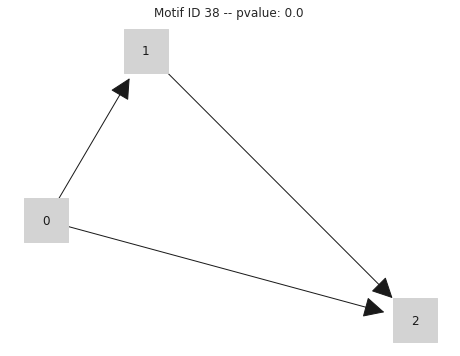

In [16]:
for alsm in als_3_general:
    for ctrm in ctr_3_general:
        if alsm == ctrm:
            alsm.view(node_color='lightgrey',node_shape='s',savefig=f"{FIG_DIR}/feedforward_motif.png")

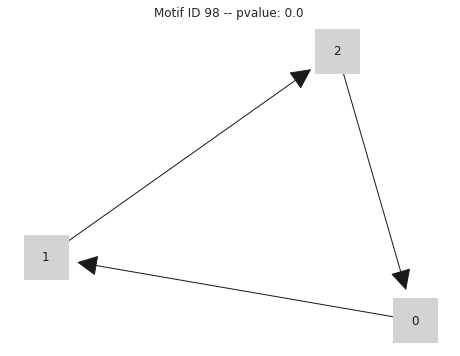

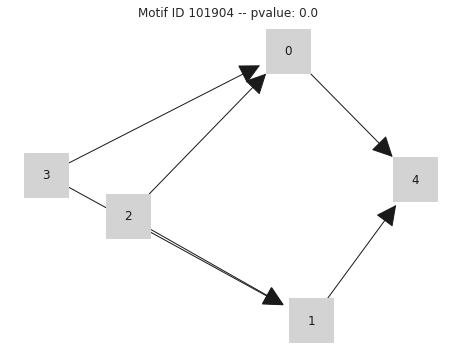

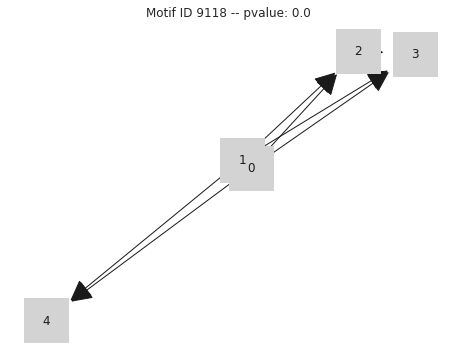

In [17]:
for m in als_only_motifs[:3]:
    m.view(node_shape='s',savefig=f"{FIG_DIR}/iPSC_als_motif_{m.motif_id}.png")

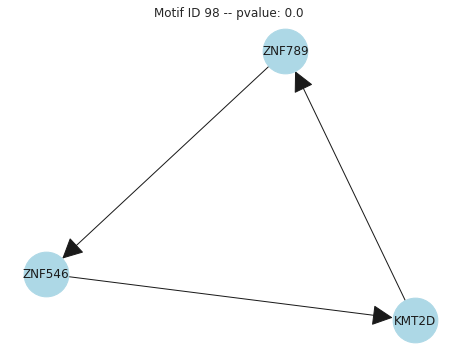

In [18]:
als_only_3_spec[0].view(node_color='lightblue',savefig=f"{FIG_DIR}/iPSC_als_motif_{als_3_mlist[0].motif_id}_{'-'.join(als_3_mlist[0].members)}.png")

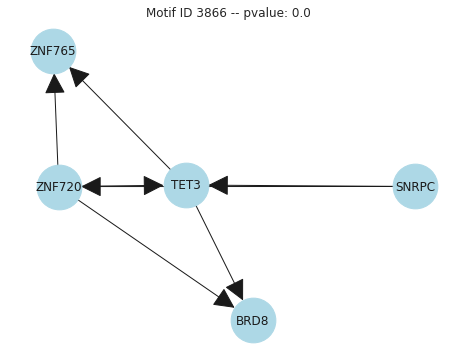

In [19]:
als_only_5_spec[0].view(node_color='lightblue',savefig=f"{FIG_DIR}/iPSC_als_motif_{als_5_mlist[0].motif_id}_{'-'.join(als_5_mlist[0].members)}.png")

## Intersect with Differentially Expressed Genes (DEGs)

In [20]:
deg_raw = pd.read_csv(f"{NBDATA_DIR}/iPSC_deseq2_condition.tsv",sep="\t")
name_map = pd.read_csv(f"{NBDATA_DIR}/iPSC_ENSG_HGNC_mapping.tsv",sep="\t").set_index('ENSG')
deg_df = pd.merge(deg_raw,name_map,left_index=True,right_index=True,how='left')\
    .reset_index()\
    .set_index('HGNC')

In [21]:
deg_df

,index,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
HGNC,,,,,,,
BBS9,ENSG00000122507,482.254543,-1.103188,0.097553,-11.308592,1.189831e-29,2.910923e-25
PVALB,ENSG00000100362,38.410147,-1.535439,0.140639,-10.917598,9.497458e-28,1.161777e-23
NPIPB15,ENSG00000196436,64.974823,3.891810,0.371523,10.475299,1.121823e-25,9.148468e-22
CHP2,ENSG00000166869,114.375049,-1.301314,0.133557,-9.743530,1.966033e-22,1.202475e-18
UBE2L6,ENSG00000156587,978.319889,-0.549121,0.056706,-9.683577,3.541067e-22,1.732644e-18
...,...,...,...,...,...,...,...
RERE-AS1,ENSG00000232912,1.278969,-0.000033,0.679851,-0.000049,9.999612e-01,NaN
ENSG00000260973,ENSG00000260973,1.404485,0.000000,3.666292,0.000000,1.000000e+00,NaN
RHOT1P2,ENSG00000203616,0.570581,0.000000,3.666292,0.000000,1.000000e+00,NaN


In [22]:
toppct_deg = deg_df.head(int(len(deg_df)*0.01)).index.values
hisig_deg = deg_df[deg_df.padj <= 1e-5].index.values

In [23]:
len(toppct_deg), len(hisig_deg)

(310, 470)

In [24]:
interesting_motifs = []

# for alsm in (als_3_mlist + als_4_mlist + als_5_mlist):
for alsm in (als_only_3_spec + als_only_4_spec + als_only_5_spec):
    if len(set(alsm.members).intersection(hisig_deg)) >= 1:
        interesting_motifs.append(alsm)
len(interesting_motifs)

10

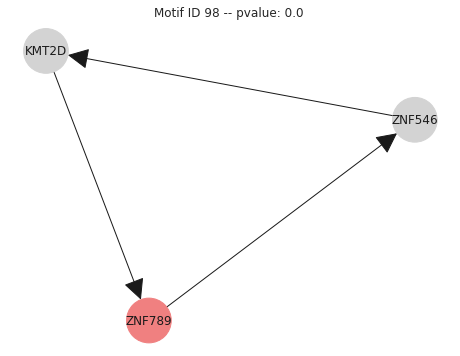

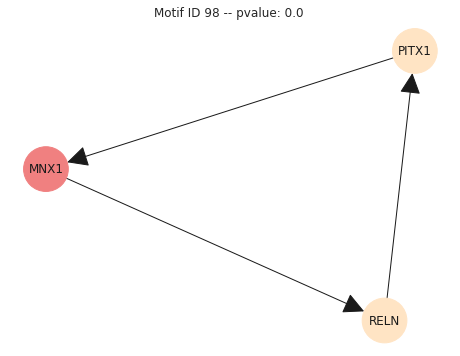

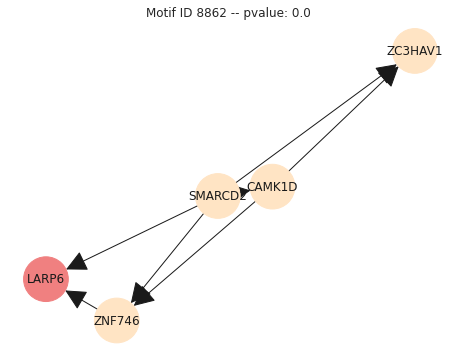

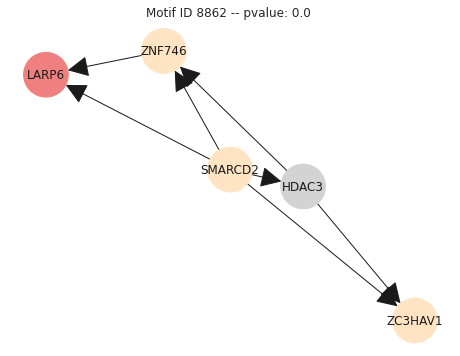

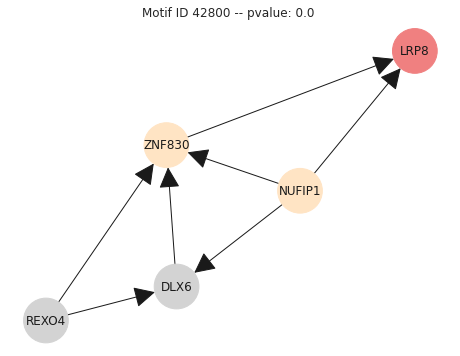

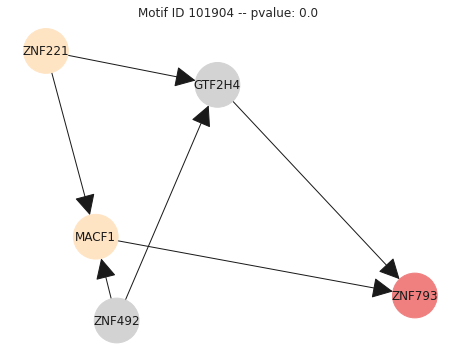

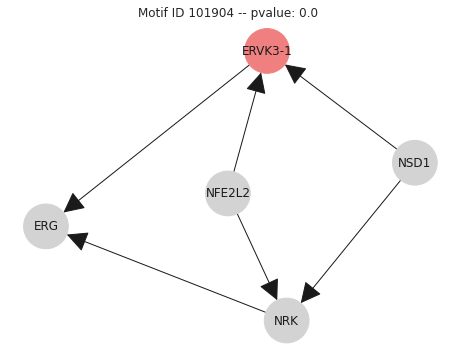

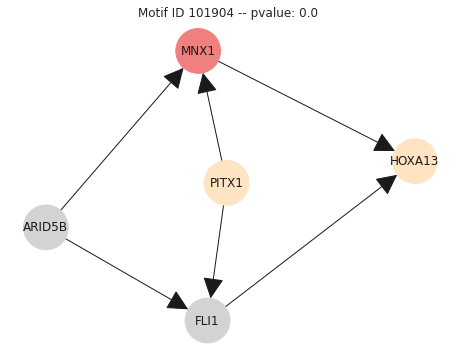

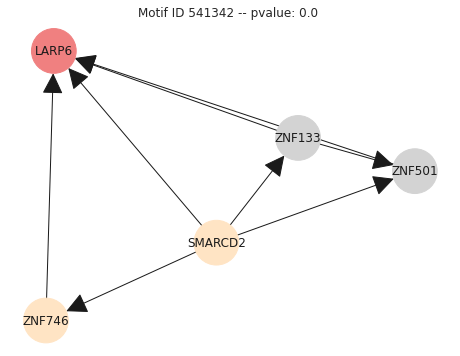

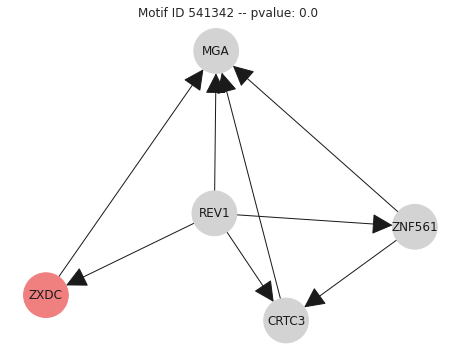

In [25]:
interesting_nodes = []

for alsm in interesting_motifs:
    node_colors = []

    for nd in alsm.members:
        if nd in hisig_deg:
            node_colors.append('lightcoral')
        elif deg_df.loc[nd,'padj'] <= 0.05:
            node_colors.append('bisque')
        else:
            node_colors.append('lightgrey')
            
    alsm.view(node_color = node_colors,
              savefig=f"{FIG_DIR}/iPSC_als_sigdeg_motif_{alsm.motif_id}_{'-'.join(alsm.members)}.png"\
             )
    # alsm.view(node_color = node_colors)
    interesting_nodes.extend(alsm.members)

## Interesting Subgraph

In [26]:
ensg_hgnc_dict = {k:v for _, (k,v) in hgnc_name_map.reset_index().iterrows()}

In [27]:
full_graph_path = f"{NBDATA_DIR}/iPSC_rna_als_genie_edgelist_0.999.tsv"
full_graph = nx.read_edgelist(full_graph_path,create_using=nx.DiGraph,data=False)
full_graph = nx.relabel_nodes(full_graph, ensg_hgnc_dict)

In [28]:
egograph_list = [nx.ego_graph(full_graph, n, radius=1) for n in interesting_nodes]
interesting_subgraph = nx.compose_all(egograph_list)
interesting_subgraph = interesting_subgraph.subgraph(set(interesting_subgraph.nodes()).intersection(deg_df.index))

In [29]:
node_colors = []

for nd in interesting_subgraph.nodes():
    if nd in hisig_deg:
        node_colors.append('lightcoral')
    elif deg_df.loc[nd,'padj'] <= 0.05:
        node_colors.append('bisque')
    else:
        node_colors.append('lightgrey')

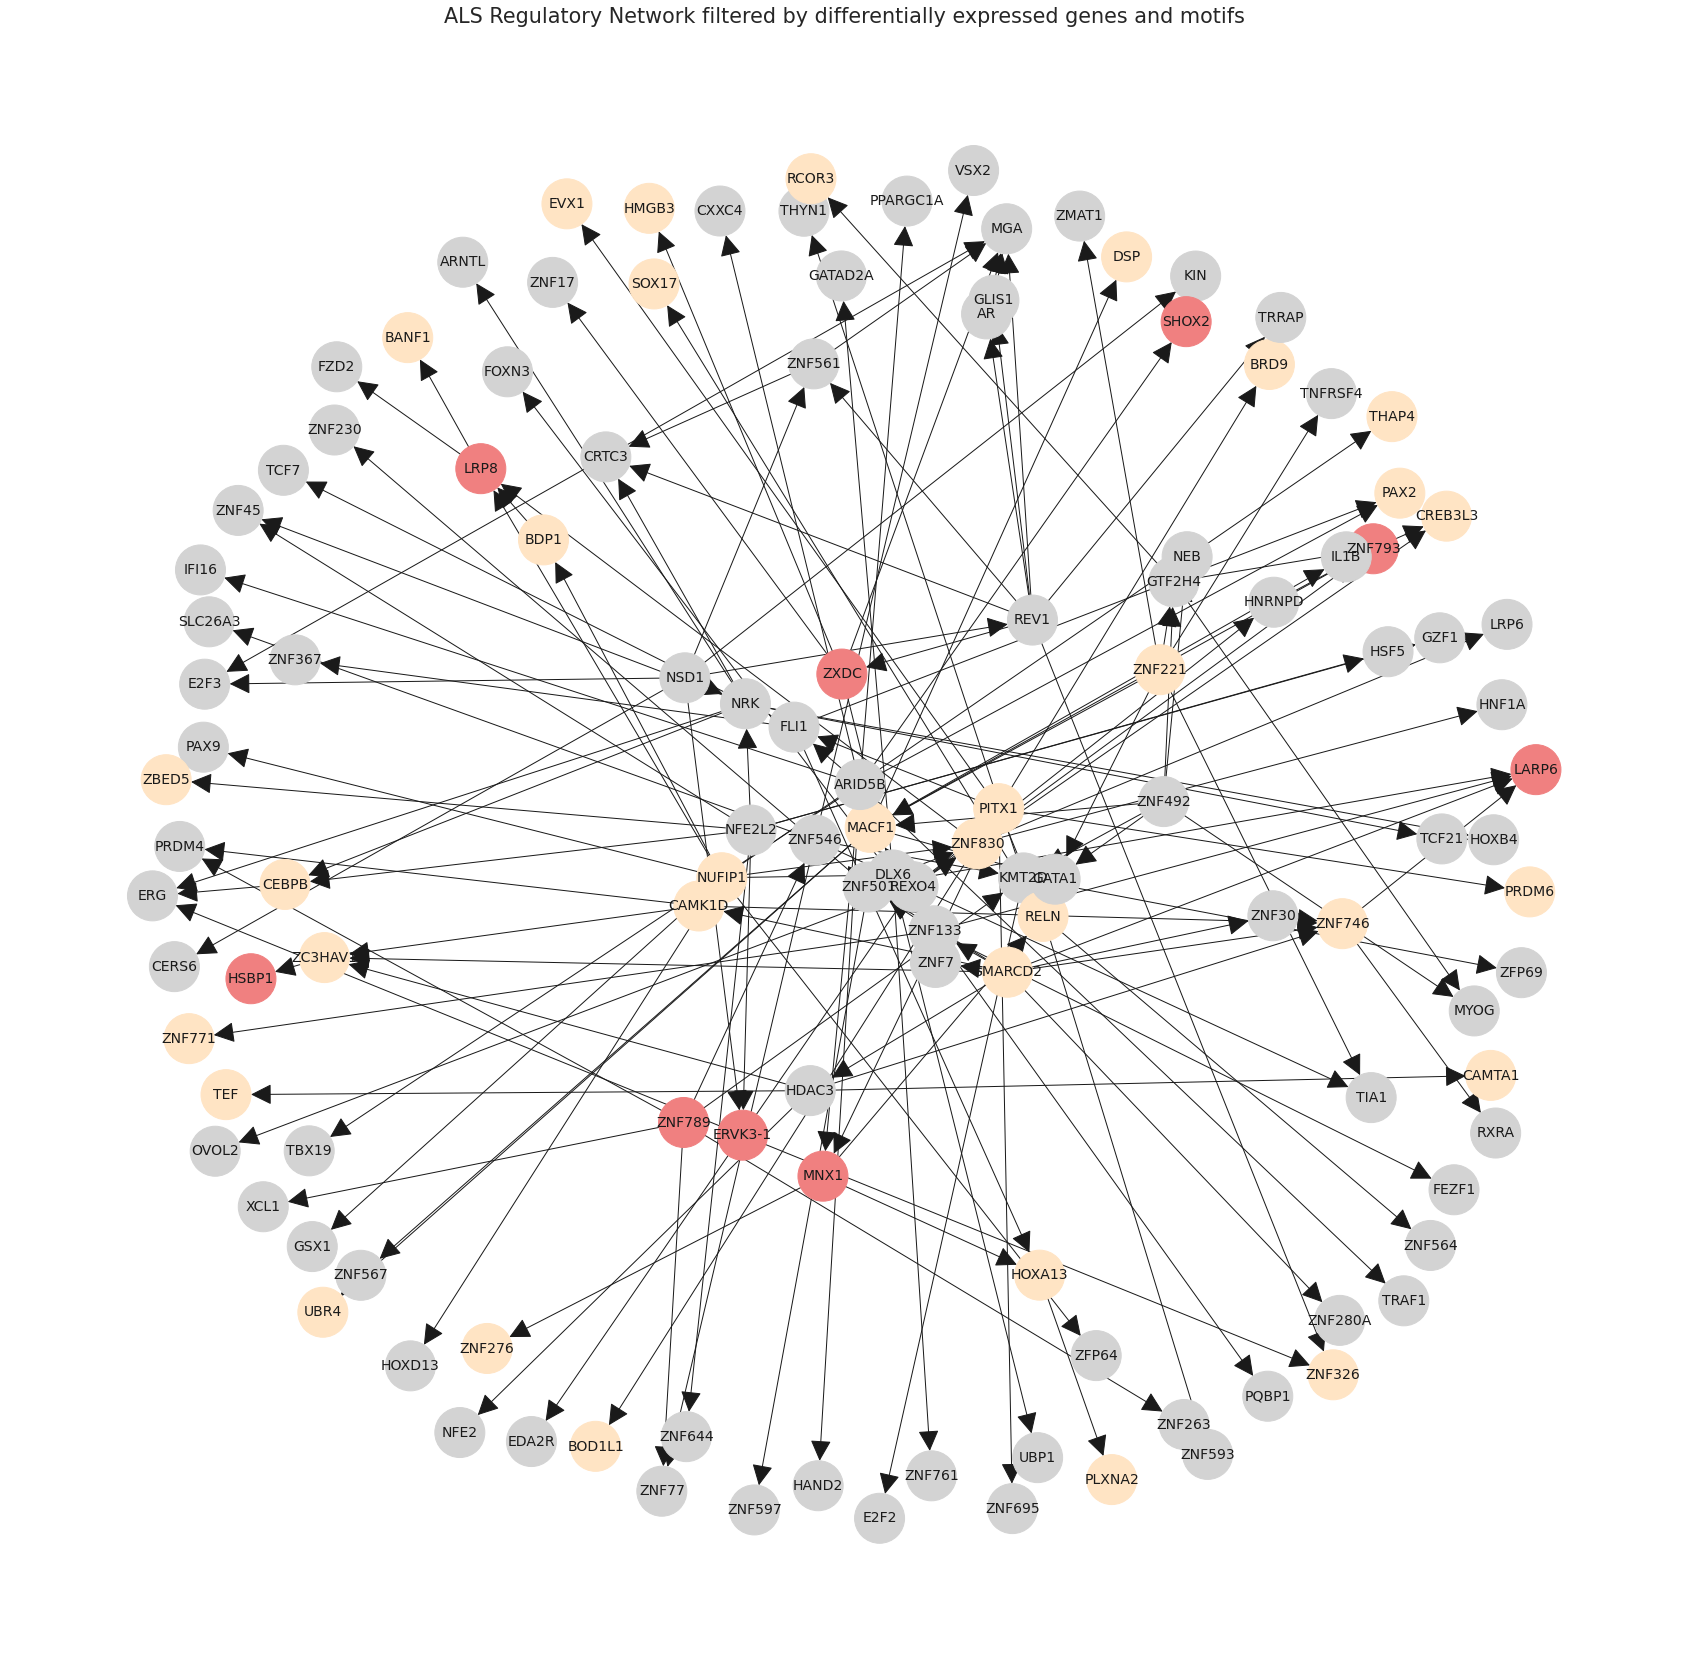

In [30]:
sns.set(style='whitegrid',font_scale=1)
fig, ax1 = plt.subplots(figsize=(30,30))
nx.draw_networkx(interesting_subgraph,
                 arrows=True,
                 arrowsize=45,
                 font_size=14,
                 node_size=2500,
                 # node_color=['lightcoral' if i else 'lightgrey' for i in deg_df.loc[list(interesting_subgraph.nodes()),:].padj <= 0.05 ],
                 node_color=node_colors,
                 ax=ax1,
                 random_state = 111,
                )
plt.axis('off')
plt.title('ALS Regulatory Network filtered by differentially expressed genes and motifs',fontsize='xx-large')
plt.savefig(f"{FIG_DIR}/iPSC_deg_interesting_subgraph.png",bbox_inches='tight')
plt.show()